## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import tensorflow as tf

## Data loading and Printing details

In [2]:
# Load data from numpy files
train_data = np.load('train_data.npy')
tr_label = np.load('train_label.npy')
test_data = np.load('test_data.npy')
ts_label = np.load('test_label.npy')

# Print shapes of the datasets to ensure correct dimensions
print(f"Shape of train_data is {train_data.shape} and of train_label is {tr_label.shape}")
print(f"Shape of test_data is {test_data.shape} and of test_label is {ts_label.shape}")

# Calculate basic statistics for the training data
data_statistics = {
    'Minimum': np.min(train_data),  # Minimum value in train_data
    'Maximum': np.max(train_data),  # Maximum value in train_data
    'Mean': np.mean(train_data),    # Mean of train_data
    'Standard Deviation': np.std(train_data),  # Standard deviation of train_data
    'Label Examples': tr_label[:10]  # First 10 labels from the training dataset
}

# Output the statistics dictionary
data_statistics


Shape of train_data is (50000, 128) and of train_label is (50000, 1)
Shape of test_data is (10000, 128) and of test_label is (10000, 1)


{'Minimum': -23.41520966868848,
 'Maximum': 25.581360537720347,
 'Mean': -1.593740250882547e-14,
 'Standard Deviation': 1.1688636581970187,
 'Label Examples': array([[6],
        [9],
        [9],
        [4],
        [1],
        [1],
        [2],
        [7],
        [8],
        [3]], dtype=uint8)}

## Preprocessing

In [3]:
def convert_to_one_hot(labels, num_classes):
    # Create an array of zeros with shape (num_samples, num_classes)
    one_hot_labels = np.zeros((labels.size, num_classes))
    
    # Use numpy advanced indexing to set the appropriate elements to one
    one_hot_labels[np.arange(labels.size), labels.flatten()] = 1
    
    return one_hot_labels

train_label = convert_to_one_hot(tr_label, 10)
test_label = convert_to_one_hot(ts_label, 10)


## Activation Function

In [4]:
import numpy as np

class Activation(object):
    """
    A class to encapsulate activation functions for neural networks.

    This class allows the creation of activation function objects that can compute
    both the function value and its derivative. Supported activation functions include
    ReLU, GELU, and softmax.

    Attributes:
        f (callable): The activation function.
        f_deriv (callable): The derivative of the activation function.

    Args:
        activation (str): The type of activation function to use ('ReLU', 'GELU', 'softmax').
                          Defaults to 'GELU'.
    """

    def __ReLU(self, x):
        """
        Computes the Rectified Linear Unit (ReLU) activation function.
        
        Args:
            x (ndarray): Input array.
        
        Returns:
            ndarray: Output array where each element is the ReLU of the corresponding element in x.
        """
        return np.maximum(0, x)

    def __ReLU_deriv(self, a):
        """
        Computes the derivative of the ReLU function.
        
        Args:
            a (ndarray): Input array, typically the output from __ReLU.
        
        Returns:
            ndarray: An array where each element is the derivative of ReLU at the corresponding element in a.
        """
        return np.where(a > 0, 1, 0)
    
    def __GELU(self, x):
        """
        Computes the Gaussian Error Linear Unit (GELU) activation function.
        
        Args:
            x (ndarray): Input array.
        
        Returns:
            ndarray: Output array where each element is the GELU of the corresponding element in x.
        """
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    
    def __GELU_deriv(self, x):
        """
        Computes the derivative of the GELU activation function.
        
        Args:
            x (ndarray): Input array.
        
        Returns:
            ndarray: An array where each element is the derivative of GELU at the corresponding element in x.
        """
        cdf = 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
        pdf = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
        return cdf + x * pdf * (1 - cdf)
    
    def __softmax(self, x):
        """
        Computes the softmax activation function.
        
        Args:
            x (ndarray): Input array.
        
        Returns:
            ndarray: Output array where each element is the softmax of the corresponding element in x.
        """
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def __softmax_deriv(self, x):
        """
        Placeholder for the derivative of the softmax function. To be implemented.
        
        Args:
            x (ndarray): Input array.
        
        Returns:
            None
        """
        pass

    def __init__(self, activation='GELU'):
        """
        Initializes the Activation object with the specified activation function.
        """
        if activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'GELU':
            self.f = self.__GELU
            self.f_deriv = self.__GELU_deriv


In [5]:
class HiddenLayer:
    """
    Represents a hidden layer in a multi-layer perceptron (MLP).

    This class allows for the creation of a fully connected layer with customizable activation functions,
    supporting advanced features like dropout and batch normalization.

    Attributes:
        input (ndarray): The input data to the layer.
        activation (callable): The activation function used in the layer.
        activation_deriv (callable): The derivative of the activation function, used in backpropagation.
        W (ndarray): Weight matrix for the layer.
        b (ndarray): Bias vector for the layer.
        grad_W (ndarray): Gradient of the weight matrix.
        grad_b (ndarray): Gradient of the bias vector.
        batch_norm (bool): Flag to indicate whether batch normalization is used.
        apply_batch_norm (bool): Flag to apply batch normalization during training.
        do_dropout (bool): Flag to apply dropout in the layer.
        dropout_rate (float): Dropout rate if dropout is applied.
        dropout_rate_last_layer (float): Dropout rate of the preceding layer (not directly used in calculations).
        mask (ndarray): Mask array used for applying dropout.

    Parameters:
        n_in (int): Number of input units to the layer.
        n_out (int): Number of output units from the layer.
        activation_last_layer (str): Type of activation function used in the previous layer.
        activation (str): Type of activation function to use in this layer.
        W (ndarray, optional): Initial weight matrix.
        b (ndarray, optional): Initial bias vector.
        dropout_rate_last_layer (float, optional): Dropout rate of the last layer.
        do_dropout (bool, optional): Indicates whether to use dropout.
        dropout_rate (float, optional): Dropout rate for this layer.
        batch_norm (bool, optional): Indicates whether to use batch normalization.
        apply_batch_norm (bool, optional): Indicates whether to apply batch normalization during the training phase.
    """
    def __init__(self, n_in, n_out, activation_last_layer='softmax', activation='ReLU', W=None, b=None,
                 dropout_rate_last_layer=0.0, do_dropout=True, dropout_rate=0.0, batch_norm=True, apply_batch_norm=True):
        self.input = None  # Placeholder for input data
        self.activation = Activation(activation).f  # Activation function for the layer


        self.activation_deriv = None
        # Set the derivative of the activation function from the previous layer for backpropagation
        self.activation_deriv = Activation(activation_last_layer).f_deriv if activation_last_layer else None

        # Initialize weights with He initialization for ReLU activation, or provided weights
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)
        self.b = np.zeros(n_out,)  # Initialize biases to zeros or provided biases

        # Placeholders for gradients
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # Momentum and Adam placeholders (for advanced optimization methods)
        self.v_W = np.zeros(self.W.shape)
        self.m_W = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)
        self.m_b = np.zeros(self.b.shape)

        # Batch normalization parameters
        self.batch_norm = batch_norm
        self.apply_batch_norm = apply_batch_norm

        if self.batch_norm:
            self.gamma = np.ones((n_out,))
            self.beta = np.zeros((n_out,))
            self.grad_gamma = np.zeros((n_out,))
            self.grad_beta = np.zeros((n_out,))
            self.v_gamma = np.zeros(self.gamma.shape)
            self.m_gamma = np.zeros(self.gamma.shape)
            self.v_beta = np.zeros(self.beta.shape)
            self.m_beta = np.zeros(self.beta.shape)

        # Dropout settings
        self.do_dropout = do_dropout
        self.dropout_rate = dropout_rate
        self.dropout_rate_last_layer = dropout_rate_last_layer
        self.mask = None  # Placeholder for dropout mask

    def forward(self, input, is_training=True):
        """
        Compute the forward pass through the hidden layer.

        Parameters:
            input (ndarray): The input data to the layer.
            is_training (bool): Flag to indicate whether the network is in training mode.

        Returns:
            ndarray: The output from the layer after applying the activation function.
        """
        
        lin_output = np.dot(input, self.W) + self.b  # Linear transformation
        self.X = lin_output

        # Batch normalization step
        if self.batch_norm and self.apply_batch_norm:
            self.mu = np.mean(lin_output, axis=0)
            self.var = np.var(lin_output, axis=0)
            self.lin_output_norm = (lin_output - self.mu) / np.sqrt(self.var + 1e-10)
            lin_output = self.gamma * self.lin_output_norm + self.beta

        # Dropout step
        if self.do_dropout and self.dropout_rate > 0 and is_training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=lin_output.shape)
            lin_output *= self.mask

        self.output = self.activation(lin_output) if self.activation else lin_output

        self.input = input
        return self.output

    def backward(self, delta, output_layer=False):
        """
        Compute the backward pass through the hidden layer.

        Parameters:
            delta (ndarray): The gradient of the loss function with respect to the output of this layer.
            output_layer (bool): Flag to indicate if this is the output layer.

        Returns:
            ndarray: The gradient of the loss function with respect to the input of this layer.
        """
        if self.do_dropout and self.dropout_rate > 0:
            delta *= self.mask  # Apply dropout mask to the gradient

        if self.batch_norm and self.apply_batch_norm:
            delta = self.batchnorm_backward(delta)  # Backprop through batch normalization

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis=0)

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)  # Backprop through activation function

        return delta

    def batchnorm_backward(self, delta):
        """
        Helper function for backpropagation through batch normalization.

        Parameters:
            delta (ndarray): Gradient of the loss with respect to the output of the batch normalization step.

        Returns:
            ndarray: Adjusted gradient after batch normalization.
        """
        # Detailed backpropagation steps for batch normalization are handled here
        dl_dlin_output = delta * self.gamma

        self.grad_gamma = np.sum(delta * self.lin_output_norm, axis=0)
        self.grad_beta = np.sum(delta, axis=0)

        m = delta.shape[0]    
        
        dl_dvar = np.sum(dl_dlin_output * (self.X - self.mu) * -0.5 * np.power(self.var + 1e-10, -1.5), axis=0)
        dl_dmu = np.sum(dl_dlin_output * -1.0 / np.sqrt(self.var + 1e-10), axis=0) + dl_dvar * np.sum(-2.0 * (self.X - self.mu), axis=0) / m
        
        dl_dx = (dl_dlin_output * 1.0 / np.sqrt(self.var + 1e-10)) + (dl_dvar * 2.0 * (self.X - self.mu) / m) + (dl_dmu / m)
        
        return dl_dx


## MLP

In [6]:
class MLP:
    """
    Implements a Multilayer Perceptron (MLP) neural network.

    This class handles the creation and management of layers, including options for dropout, 
    batch normalization, and L2 normalization as regularization techniques to improve the 
    training results and prevent overfitting.

    Attributes:
        layers (list): A list of HiddenLayer instances that form the network's layers.
        activation (list): Activation functions to use for each layer.
        batch_norm (bool): If True, enables batch normalization on applicable layers.
        do_l2_norm (bool): If True, applies L2 regularization to the weights.
        t (int): Counter for the number of updates, used for bias correction in Adam optimization.
    """
    def __init__(self, layers, activation=[None,'ReLU','softmax'],dropout_rate=[None, 0.5, 0.0], do_dropout = True ,batch_norm= True, do_l2_norm = True):
        """
        Initializes the MLP with the specified architecture and hyperparameters.

        Args:
            layers (list of int): Number of units in each layer.
            activation (list of str): Activation functions for each layer.
            dropout_rate (list of float): Dropout rates for each layer.
            do_dropout (bool): Flag to enable dropout regularization.
            batch_norm (bool): Flag to enable batch normalization.
            do_l2_norm (bool): Flag to enable L2 weight regularization.
        """

        self.layers=[]
        self.params=[]

        self.activation=activation
        self.batch_norm = batch_norm
        self.do_l2_norm = do_l2_norm

        self.t = 0   # Time step counter for Adam optimizer


        assert len(dropout_rate) == len(layers)  #Dropout rate list must match the layers list in length.

        for i in range(len(layers)-1):
            apply_bn = False if i == len(layers) - 2 else True # Do not apply batch normalization on the last layer

            current_layer = HiddenLayer(
                n_in= layers[i],
                n_out= layers[i+1],
                activation_last_layer= activation[i],
                activation= activation[i+1],
                dropout_rate_last_layer = dropout_rate[i],
                dropout_rate = dropout_rate[i+1],
                batch_norm = batch_norm,
                do_dropout = do_dropout,
                apply_batch_norm=apply_bn
            )
            self.layers.append(current_layer)

    def forward(self,input, is_training = True):
        """
        Performs the forward pass through all layers of the network.

        Args:
            input (array-like): Input data.
            is_training (bool): Indicates whether the network is in training mode.

        Returns:
            array-like: The output from the final layer of the network.
        """
        for layer in self.layers:
            output=layer.forward(input, is_training)
            input=output
        return output


    def Cross_Entropy(self,y,y_hat, epsilon = 1e-10 , lamb = 0.001):
        """
        Computes the cross-entropy loss and the gradient for backpropagation.

        Args:
            y (array-like): True labels.
            y_hat (array-like): Predicted probabilities.
            epsilon (float): Small number to stabilize the logarithm calculation.
            lamb (float): Regularization strength.

        Returns:
            tuple: The computed cross-entropy loss and the gradient (delta).
        """
        y_hat = np.clip(y_hat, epsilon, 1. - epsilon) # Clipping for numerical stability
        loss = -np.sum(y * np.log(y_hat))/len(y_hat)  # Cross-entropy loss

        if self.do_l2_norm: # L2 regularization
            l2_norm = 0
            for layer in self.layers:
                l2_norm += np.sum(layer.W ** 2)
            l2_norm = lamb * 0.5 * l2_norm  # Add L2 regularization term to loss
            loss += l2_norm
            
            for layer in self.layers:  # Add L2 gradient to weights
                layer.grad_W += lamb * layer.W
        delta = y_hat - y   # Gradient for backpropagation
        return loss, delta
                        
    def backward(self,delta):
        """
        Performs the backward pass through all layers of the network starting from the output layer.

        Args:
            delta (array-like): Gradient of the loss with respect to the output of the last layer.
        """
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    def update_Momentum(self,lr,momentum):
        """
        Update the model parameters using momentum-based optimization.

        Args:
            lr (float): Learning rate.
            momentum (float): Momentum coefficient.

        Details:
            This function adjusts the weights and biases according to the momentum
            update rule. It also updates parameters for batch normalization if enabled.
        """
        for layer in self.layers:
            layer.v_W = momentum * layer.v_W + lr * layer.grad_W
            layer.v_b = momentum * layer.v_b + lr * layer.grad_b

            layer.W -= layer.v_W
            layer.b -= layer.v_b

            if self.batch_norm:
                layer.v_gamma = layer.v_gamma + lr * layer.grad_gamma
                layer.v_beta = layer.v_beta + lr * layer.grad_beta

                layer.gamma -= layer.v_gamma
                layer.beta -= layer.v_beta
            

    def update_adam(self,lr, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-10):
        """
        Update the model parameters using the Adam optimization algorithm.

        Args:
            lr (float): Learning rate.
            beta1 (float): Decay rate for the first moment estimates.
            beta2 (float): Decay rate for the second moment estimates.
            epsilon (float): Small constant for numerical stability.

        Details:
            This function adjusts the weights, biases, and batch normalization parameters
            (if enabled) using the Adam optimization strategy. This includes bias correction.
        """
        for layer in self.layers:
        # update
            layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.grad_W
            layer.v_W = beta2 * layer.v_W + (1 - beta2) * (layer.grad_W ** 2)
            layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.grad_b
            layer.v_b = beta2 * layer.v_b + (1 - beta2) * (layer.grad_b ** 2)

            # bias correction
            m_W_hat = layer.m_W / (1 - beta1 ** (self.t + 1))
            v_W_hat = layer.v_W / (1 - beta2 ** (self.t + 1))
            m_b_hat = layer.m_b / (1 - beta1 ** (self.t + 1))
            v_b_hat = layer.v_b / (1 - beta2 ** (self.t + 1))

            # update the weights and biases
            layer.W -= lr * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
            layer.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

            if self.batch_norm:
                layer.m_gamma = beta1 * layer.m_gamma + (1 - beta1) * layer.grad_gamma
                layer.m_beta = beta1 * layer.m_beta + (1 - beta1) * layer.grad_beta
                layer.v_gamma = beta2 * layer.v_gamma + (1 - beta2) * (layer.grad_gamma ** 2)
                layer.v_beta = beta2 * layer.v_beta + (1 - beta2) * (layer.grad_beta ** 2)

                m_gamma_hat = layer.m_gamma / (1 - beta1 ** (self.t + 1))
                m_beta_hat = layer.m_beta / (1 - beta1 ** (self.t + 1))
                v_gamma_hat = layer.v_gamma / (1 - beta2 ** (self.t + 1))
                v_beta_hat = layer.v_beta / (1 - beta2 ** (self.t + 1))

                layer.gamma -= lr * m_gamma_hat / (np.sqrt(v_gamma_hat) + epsilon)
                layer.beta -= lr * m_beta_hat / (np.sqrt(v_beta_hat) + epsilon)
            
            self.t += 1
    
    def fit_mini_batch(self, X, y, learning_rate=0.1, momentum=0.9, epochs=100, batch_size=100):
        """
        Trains the network using mini-batch stochastic gradient descent.

        Args:
            X (array-like): Input data or features.
            y (array-like): Input targets.
            learning_rate (float): Learning rate for updates.
            momentum (float): Momentum factor for momentum update rule.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each mini-batch.

        Returns:
            array: Array of loss values per epoch, showing the training progress.
        """
        X = np.array(X)
        y = np.array(y)
        to_return = np.zeros(epochs) # Losses per epoch

        for k in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, len(X), batch_size):
                end = start + batch_size
                batch_X, batch_y = X_shuffled[start:end], y_shuffled[start:end]

                # Forward pass
                y_hat = self.forward(batch_X)

                # Calculate loss and delta for backpropagation
                batch_loss, delta = self.Cross_Entropy(batch_y, y_hat)

                # Backward pass
                self.backward(delta)

                # Update parameters with momentum
                self.update_adam(learning_rate, momentum)


            # Evaluate the average loss over all mini-batches for this epoch
            to_return[k] = np.mean(batch_loss)
            print("Batch los : ", to_return[k])
        return to_return

    def predict(self, x):
        """
        Makes predictions using the trained network model.

        Args:
            x (array-like): Input data for prediction.

        Returns:
            array: Predicted classes or values for the input data.
        """
        x = np.array(x)
        num_samples = x.shape[0]
        num_classes = self.layers[-1].W.shape[1]  
        output = np.zeros((num_samples, num_classes))
        for i in range(num_samples):
            output[i] = self.forward(x[i], is_training = False)
        return output



Batch los :  2.2659300335229706
Batch los :  2.121166259444457
Batch los :  2.0168106823882
Batch los :  2.0149277288350547
Batch los :  1.97284104251852
Batch los :  2.0741150738442204
Batch los :  1.9201865060088283
Batch los :  2.0424969732515548
Batch los :  1.9547009958086345
Batch los :  1.9027915414985421
Batch los :  1.948567155945998
Batch los :  1.8023236766082644
Batch los :  1.8268070675971408
Batch los :  1.8988290815696107
Batch los :  1.7591818145379536
Batch los :  1.8647908624701837
Batch los :  1.9254177949313194
Batch los :  1.7397558027491242
Batch los :  1.9369914305688276
Batch los :  1.9364097416189041
Batch los :  1.8435988397525511
Batch los :  1.6150266650860063
Batch los :  1.5151355376415716
Batch los :  1.7518796755721737
Batch los :  1.625861570511252
Batch los :  1.7232985929932723
Batch los :  1.8265210496549174
Batch los :  1.781958071814724
Batch los :  1.651414198086144
Batch los :  1.8240798795948021
Batch los :  1.5903591055426398
Batch los :  1.677

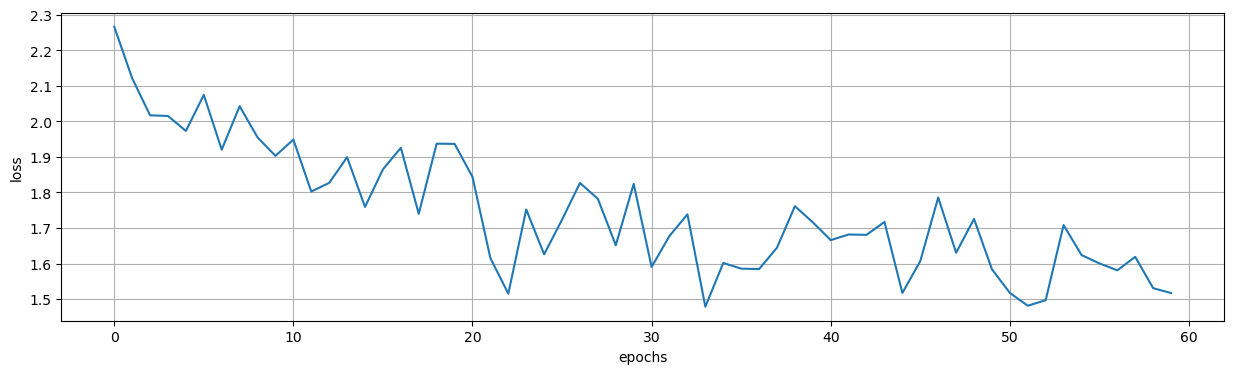

In [15]:
### Try different MLP models
# we can compare the loss change graph to under how the network parameters (such as number of layers and activation functions),
# could affect the performance of network.
input_data = train_data
output_data = train_label
nn = MLP([128,256,128,64,10], [None,'GELU','GELU','GELU','softmax'], [None,0.3,0.3,0.3,0.0],do_dropout = False, batch_norm= True, do_l2_norm = True)
CE_mini_batch = nn.fit_mini_batch(input_data, output_data, learning_rate=0.0001, momentum= 0.9 , epochs = 60, batch_size= 128)
print('loss:%f'%CE_mini_batch[-1])
pl.figure(figsize=(15,4))
pl.plot(CE_mini_batch)
pl.xlabel('epochs')
pl.ylabel('loss')
pl.grid()

## Evaluation

1. accuracy
2. confusion matrix
3. precision
4. recall
5. f1 score



In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(predictions, true_labels):
    """
    Evaluates the performance of a classification model by calculating key metrics.

    Args:
        predictions (np.ndarray): Predicted labels for the data.
        true_labels (np.ndarray): True labels for the data.

    Returns:
        dict: A dictionary containing the accuracy, confusion matrix, precision, recall, and F1 score.
    """
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(cm)

    # Calculate precision, recall, and F1 score using macro averaging
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    print(f'Precision: {precision*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    print(f'F1 Score: {f1*100:.2f}%')

    # Return all metrics in a dictionary
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Assuming you have `output` and `test_label` from your neural network predictions

output = nn.predict(test_data)
predicted_classes = np.argmax(output, axis = 1)
true_classes = np.argmax(test_label, axis=1)

# Evaluate the model
metrics = evaluate_model(predicted_classes, true_classes)

# Optionally, print the metrics dictionary
print(metrics)


Accuracy: 43.19%
Confusion Matrix:
[[631  71  58  50   0   8   8   8 113  53]
 [ 74 679  19  37   0   3   8   8  90  82]
 [135  52 334 237  10  72  85  24  34  17]
 [ 66  73  86 511   3 134  45  19  33  30]
 [120  77 168 251  81  71 141  41  32  18]
 [ 65  39  85 366   9 301  42  27  39  27]
 [ 39  82  67 299   6  55 402   5  27  18]
 [109  87  99 164  17  75  39 320  28  62]
 [150  79  18  28   1  15   3   2 651  53]
 [100 258  29  58   0  10   8  13 115 409]]
Precision: 48.14%
Recall: 43.19%
F1 Score: 41.73%
{'accuracy': 0.4319, 'confusion_matrix': array([[631,  71,  58,  50,   0,   8,   8,   8, 113,  53],
       [ 74, 679,  19,  37,   0,   3,   8,   8,  90,  82],
       [135,  52, 334, 237,  10,  72,  85,  24,  34,  17],
       [ 66,  73,  86, 511,   3, 134,  45,  19,  33,  30],
       [120,  77, 168, 251,  81,  71, 141,  41,  32,  18],
       [ 65,  39,  85, 366,   9, 301,  42,  27,  39,  27],
       [ 39,  82,  67, 299,   6,  55, 402,   5,  27,  18],
       [109,  87,  99, 164,  1

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model_latex(predictions, true_labels):
    """
    Evaluates the performance of a classification model and returns the metrics formatted as LaTeX table code.

    Args:
        predictions (np.ndarray): Predicted labels for the data.
        true_labels (np.ndarray): True labels for the data.

    Returns:
        str: LaTeX table code representing the evaluation metrics.
    """
    # Calculate metrics
    accuracy = np.mean(predictions == true_labels)
    cm = confusion_matrix(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    # Start building LaTeX table code
    latex_str = "\\begin{table}[H]\n\\centering\n"
    latex_str += "\\begin{tabular}{|c|c|}\n\\hline\n"
    latex_str += "Metric & Value \\\\ \\hline\n"
    latex_str += f"Accuracy & {accuracy*100:.2f}\\% \\\\ \\hline\n"
    latex_str += f"Precision & {precision*100:.2f}\\% \\\\ \\hline\n"
    latex_str += f"Recall & {recall*100:.2f}\\% \\\\ \\hline\n"
    latex_str += f"F1 Score & {f1*100:.2f}\\% \\\\ \\hline\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\caption{Evaluation Metrics}\n"
    latex_str += "\\end{table}\n"

    # Add confusion matrix to the LaTeX string
    latex_str += "\\begin{table}[H]\n\\centering\n"
    latex_str += "\\begin{tabular}{c" + "c" * cm.shape[1] + "}\n\\hline\n"
    latex_str += " & " + " & ".join([f"Predicted {i}" for i in range(cm.shape[1])]) + " \\\\ \\hline\n"
    for idx, row in enumerate(cm):
        latex_str += f"Actual {idx} & " + " & ".join(map(str, row)) + " \\\\ \\hline\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\caption{Confusion Matrix}\n"
    latex_str += "\\end{table}\n"

    return latex_str

# Assuming you have `output` and `test_label` from your neural network predictions
predicted_classes = np.argmax(output, axis=1)
true_classes = np.argmax(test_label, axis=1)

# Evaluate the model and get LaTeX table
latex_output = evaluate_model_latex(predicted_classes, true_classes)
print(latex_output)


\begin{table}[H]
\centering
\begin{tabular}{|c|c|}
\hline
Metric & Value \\ \hline
Accuracy & 43.19\% \\ \hline
Precision & 48.14\% \\ \hline
Recall & 43.19\% \\ \hline
F1 Score & 41.73\% \\ \hline
\end{tabular}
\caption{Evaluation Metrics}
\end{table}
\begin{table}[H]
\centering
\begin{tabular}{ccccccccccc}
\hline
 & Predicted 0 & Predicted 1 & Predicted 2 & Predicted 3 & Predicted 4 & Predicted 5 & Predicted 6 & Predicted 7 & Predicted 8 & Predicted 9 \\ \hline
Actual 0 & 631 & 71 & 58 & 50 & 0 & 8 & 8 & 8 & 113 & 53 \\ \hline
Actual 1 & 74 & 679 & 19 & 37 & 0 & 3 & 8 & 8 & 90 & 82 \\ \hline
Actual 2 & 135 & 52 & 334 & 237 & 10 & 72 & 85 & 24 & 34 & 17 \\ \hline
Actual 3 & 66 & 73 & 86 & 511 & 3 & 134 & 45 & 19 & 33 & 30 \\ \hline
Actual 4 & 120 & 77 & 168 & 251 & 81 & 71 & 141 & 41 & 32 & 18 \\ \hline
Actual 5 & 65 & 39 & 85 & 366 & 9 & 301 & 42 & 27 & 39 & 27 \\ \hline
Actual 6 & 39 & 82 & 67 & 299 & 6 & 55 & 402 & 5 & 27 & 18 \\ \hline
Actual 7 & 109 & 87 & 99 & 164 & 17 & 75 & 39